In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.ensemble import RandomForestRegressor
import scipy.signal

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("/kaggle/input/dapprojekt24-1/train.csv") 
test_data = pd.read_csv("/kaggle/input/dapprojekt24-1/test.csv") 

# EDA

In this part explanatory data analysis is done in the same way as the first mandatory notebook.

In [4]:
data = data[~data['Symbol'].isin(['VLTO', 'KVUE', 'GEHC', 'CTVA', 'FOXA'])]
grouped_data = data.groupby('Symbol').apply(lambda x: x.isnull().sum(), include_groups=False)
grouped_data = grouped_data[~(grouped_data == 0).all(axis=1)]

In [5]:
def find_missing_value_intervals(stock):
    missing_intervals = []
    current_interval_start = None
    current_interval_end = None

    for index, row in stock.iterrows():
        if pd.isnull(row).any(): # check if any values in the current row are missing
            current_interval_end = row['Date']
            if current_interval_start is None:
                current_interval_start = row['Date']
        else:
            if current_interval_start is not None:
                missing_intervals.append((current_interval_start, current_interval_end))
                return missing_intervals

    return missing_intervals

In [6]:
data['Date'] = pd.to_datetime(data['Date']).dt.date
grouped = data.groupby('Symbol') # group data by 'Symbol'
symbols = grouped_data.index.tolist() # get names of stock that have missing values

missing_value_intervals = {}
for name, group in grouped:
    if name in symbols: # only if name of group is in list of stocks that have missing values
        missing_value_intervals[name] = find_missing_value_intervals(group)

sorted_missing_values = sorted(missing_value_intervals.items(), key=lambda x:x[1]) # sort intervals
for stock, intervals in sorted_missing_values:
    for interval in intervals:
        start_date = interval[0].strftime('%d.%m.%Y') 
        end_date = interval[1].strftime('%d.%m.%Y')  

for stock, intervals in sorted_missing_values:
    if stock != 'MMM': # remove all stocks except 'MMM'
        for interval in intervals:
            start_date, end_date = interval
            rows_to_remove = data[(data['Symbol'] == stock) & (data['Date'] >= start_date) & (data['Date'] <= end_date)]
            data.drop(rows_to_remove.index, inplace=True)

interpolated_row = data['Volume'].interpolate()
data['Volume'] = interpolated_row
data.loc[data['High'] < 0, 'High'] = data.loc[data['High'] < 0, 'Close'] 

In [7]:
data.isna().sum()

Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Target       0
Id           0
dtype: int64

In [8]:
test_data.fillna(0, inplace=True)

# 1. Data preparation

In [9]:
def plot_graphs(data, symbol): # plot almost all numerical fetures on one graph
    columns = ['Adj Close', 'Close', 'High', 'Low', 'Open']
    for column in columns:
        plt.plot(data['Date'], data[column], label=column)
    plt.tick_params(axis='x', rotation=40)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.title(f'Stock {symbol}')
    plt.show()

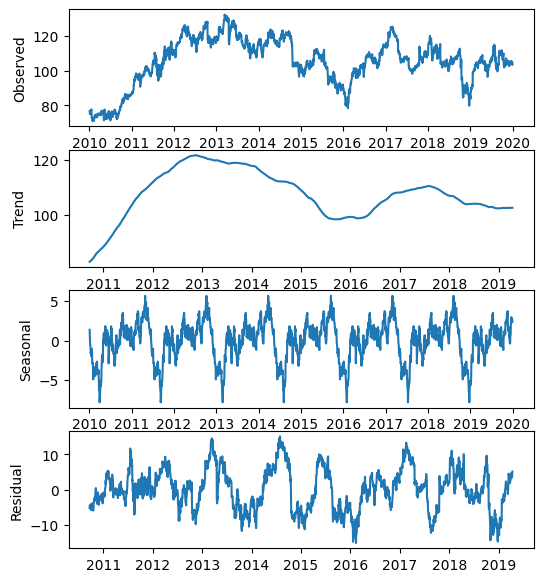

In [10]:
def decompose_time_series(stock_data, column='Adj Close'):
    result = seasonal_decompose(stock_data[column], period=365)
    return result

df_season = data.copy()
df_season['Date'] = pd.to_datetime(df_season['Date'])
df_season = df_season.set_index('Date')

stock_data = df_season[df_season['Symbol'] == 'IBM']
result = decompose_time_series(stock_data)

fig, ax = plt.subplots(4, 1, figsize=(6, 7))
ax[0].plot(stock_data['Adj Close'])
ax[1].plot(result.trend)
ax[2].plot(result.seasonal)
ax[3].plot(result.resid)

ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

plt.show()

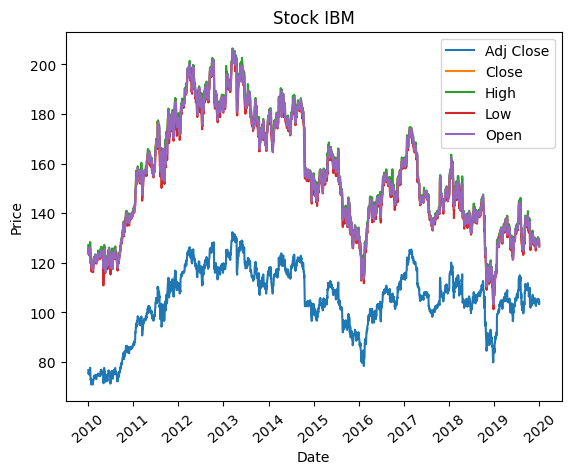

In [11]:
plot_graphs(data[data['Symbol'] == 'IBM'], 'IBM')

For stock that has seasonality, IBM was chosen. The seasonality is especially visible on the later point in time.

# 2. Exponential smoothing 

In [12]:
X_train, X_test = train_test_split(stock_data['Adj Close'], test_size=0.3, shuffle=False)
X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

In [13]:
res = {}

def convert_inputs_to_strings(func):
    def wrapper(*args, **kwargs):
        str_kwargs = {key: str(value) for key, value in kwargs.items()}
        inputs_as_string = f"{str_kwargs}"
        result = func(inputs_as_string, *args, **kwargs)
        return result
    return wrapper

@convert_inputs_to_strings
def ExpSmFun(inputs_as_string, X_train, X_test, trend=None, damped_trend=False, seasonal=None, seasonal_periods=None, initialization_method='estimated', initial_level=None, initial_trend=None, initial_seasonal=None, use_boxcox=False):
    global res
    model = ExponentialSmoothing(X_train, seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal)
    fit = model.fit()
    pred = fit.forecast(len(X_test))
    
    mse = np.sqrt(mean_squared_error(X_test, pred))
    mae = mean_absolute_error(X_test, pred)
    res[inputs_as_string] = {
        'mse': mse,
        'mae': mae,
        'predictions': pred
    }


ExpSmFun(X_train, X_test, seasonal_periods=365, trend='additive', seasonal='additive')
ExpSmFun(X_train, X_test, seasonal_periods=4, trend='additive', seasonal='additive')
ExpSmFun(X_train, X_test, seasonal_periods=365, trend='multiplicative', seasonal='multiplicative')
ExpSmFun(X_train, X_test, seasonal_periods=4, trend='multiplicative', seasonal='multiplicative')

df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"{'seasonal_periods': '365', 'trend': 'additive', 'seasonal': 'additive'}",19.037804,16.713608
"{'seasonal_periods': '4', 'trend': 'additive', 'seasonal': 'additive'}",19.364441,17.237517
"{'seasonal_periods': '365', 'trend': 'multiplicative', 'seasonal': 'multiplicative'}",15.760292,13.664746
"{'seasonal_periods': '4', 'trend': 'multiplicative', 'seasonal': 'multiplicative'}",16.152978,14.259250


In [14]:
def line_graph_pred(X_train, X_test, pred, conf=None):
    plt.figure(figsize=(8, 4))
    plt.plot(X_train.index, X_train)
    plt.plot(X_test.index, X_test)
    plt.plot(X_test.index, pred)
    if conf is not None:
        plt.plot(X_test.index, conf['lower Adj Close'], color='b', alpha=0.2)
        plt.plot(X_test.index, conf['upper Adj Close'], color='b', alpha=0.2,)

    plt.show()

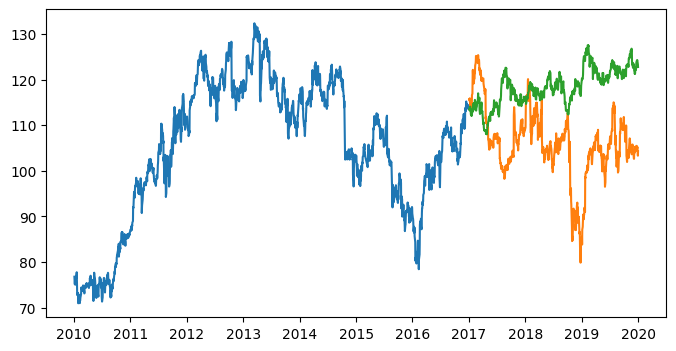

In [15]:
key = "{'seasonal_periods': '365', 'trend': 'multiplicative', 'seasonal': 'multiplicative'}"
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

After some adjusting hiperparameters, the smallest errors are obtained when seasonal period last 365 days and trend is multiplicative. Even though that is the smallest error the prediction is still not very accurate.

# 3. ARIMA 

In [16]:
X_train, X_test = train_test_split(stock_data['Adj Close'], test_size=0.3, shuffle=False)
X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

In [17]:
def ARIMA_model(train_series, test_series, p=0, d=0, q=0, s=0, season=False):
    if season is False:
        model = ARIMA(train_series, order=(p,d,q))
    else:
        model = ARIMA(train_series, seasonal_order=(p,d,q,s))
    fit = model.fit()
    pred = fit.forecast(steps=len(test_series))
    
    mse = np.sqrt(mean_squared_error(test_series, pred))
    mae = mean_absolute_error(test_series, pred)
    
    forecast = fit.get_forecast(steps=len(test_series))
    conf_int = forecast.conf_int(alpha=0.05)

    return mse, mae, (p, d, q), s, pred, conf_int

## 3.1. order = (0, 0, 0)

Root Mean Square Error: 7.822148361975945
Mean Absolute Error: 5.493163241447583



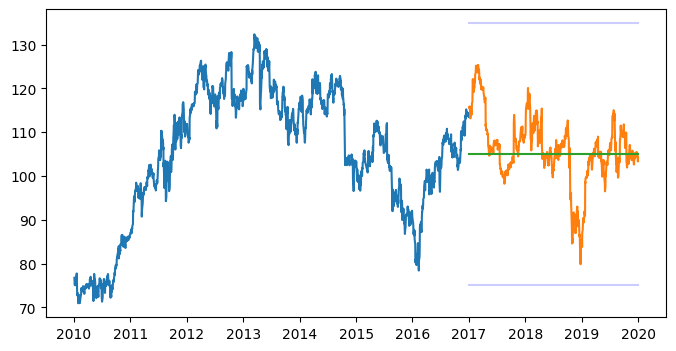

In [18]:
mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 0, 0, 0)

print(f'Root Mean Square Error: {mse}')
print(f'Mean Absolute Error: {mae}\n')
line_graph_pred(X_train, X_test, pred, conf=conf_int)

Using ARIMA and predefined parameters, errors are much lower than when using ExponentialSmoothing, but when the lines are plotted we can see that the prediction is very bad, the prediction is simply a straight line.

Confidence interval is simply the biggest value obtained while training and one of the smallest.

This prediction is not very useful.

## 3.2. order = (p, 0, 0)

In [19]:
res = {}
for p in range(1, 11):
    mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, p, 0, 0)
    res[str((p, d, q))] = {
        'mse': mse,
        'mae': mae,
        'predictions': pred,
        'interval': conf_int
    }
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(1, 0, 0)",7.259114,5.327250
"(2, 0, 0)",7.213923,5.282080
"(3, 0, 0)",7.252467,5.320653
"(4, 0, 0)",7.309632,5.378904
"(5, 0, 0)",7.383371,5.453566
"(6, 0, 0)",7.504600,5.575324
"(7, 0, 0)",7.557413,5.627947
"(8, 0, 0)",7.633855,5.703680
"(9, 0, 0)",7.770488,5.839960
"(10, 0, 0)",7.732889,5.802379


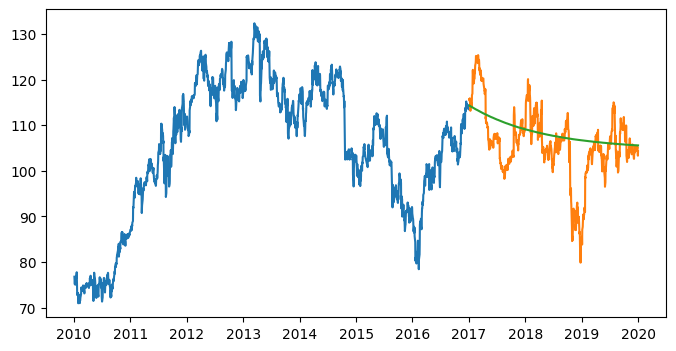

In [20]:
key = '(2, 0, 0)'
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

By adjusting the parameter p, the error is slightly better. This parameter determines autoregression. Autoregression is dependency of a certain value on the previous value.

## 3.3. order = (0, 0, q)

In [21]:
res = {}
for q in range(1, 16):
    mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 0, 0, q)
    res[str((p, d, q))] = {
        'mse': mse,
        'mae': mae,
        'predictions': pred,
        'interval': conf_int
    }
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(0, 0, 1)",7.815853,5.487255
"(0, 0, 2)",7.809305,5.479491
"(0, 0, 3)",7.805163,5.475581
"(0, 0, 4)",7.801020,5.471400
"(0, 0, 5)",7.788487,5.453254
"(0, 0, 6)",7.780864,5.442018
"(0, 0, 7)",7.782748,5.447434
"(0, 0, 8)",7.772086,5.432023
"(0, 0, 9)",7.770974,5.433055
"(0, 0, 10)",7.766056,5.426360


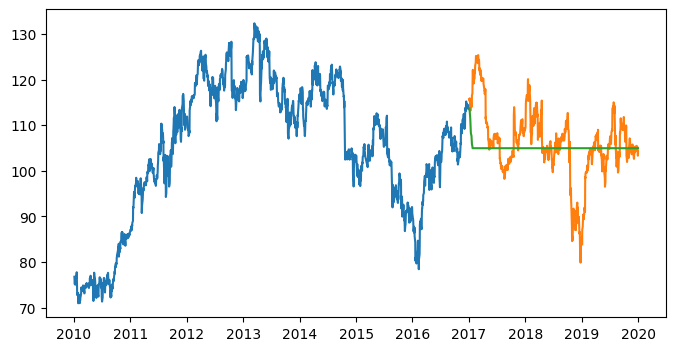

In [22]:
key = '(0, 0, 13)'
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

The parameter determines the moving average of the time series.

## 3.4. order = (0, d, 0)

In [23]:
res = {}
for d in range(1, 6):
    mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 0, d, 0)
    res[str((p, d, q))] = {
        'mse': mse,
        'mae': mae,
        'predictions': pred,
        'interval': conf_int
    }
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(0, 1, 0)",1.127059e+01,9.481136e+00
"(0, 2, 0)",3.658099e+02,3.175064e+02
"(0, 3, 0)",1.577750e+05,1.177305e+05
"(0, 4, 0)",5.255956e+07,3.481420e+07
"(0, 5, 0)",1.614889e+10,9.705671e+09


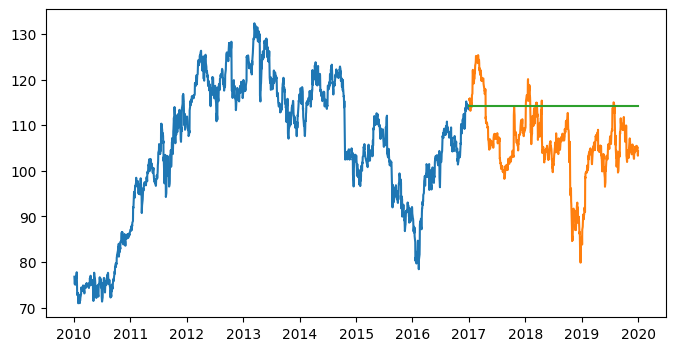

In [24]:
key = '(0, 1, 0)'
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

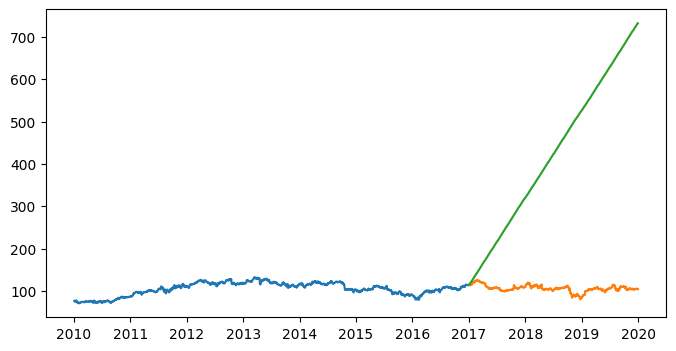

In [25]:
key = '(0, 2, 0)'
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

The parameter d determines the integration of the time series and it removes the trend from the signal.

## 3.5. order = (p, d, q)

In [26]:
res = {}

for p in range(1, 5):
    for q in range(10, 16):
        mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, p, 0, q)
        res[str((p, d, q))] = {
            'mse': mse,
            'mae': mae,
            'predictions': pred,
            'interval': conf_int
        }
        
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(1, 0, 10)",7.556834,5.627499
"(1, 0, 11)",7.487338,5.558358
"(1, 0, 12)",7.551961,5.622524
"(1, 0, 13)",7.514920,5.585729
"(1, 0, 14)",7.436500,5.507758
"(1, 0, 15)",7.479721,5.551131
"(2, 0, 10)",7.198635,5.264501
"(2, 0, 11)",7.211374,5.276694
"(2, 0, 12)",7.647100,5.718667
"(2, 0, 13)",7.546150,5.618690


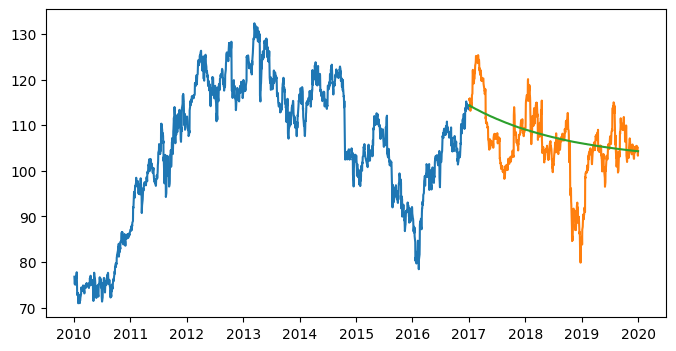

In [27]:
key = '(3, 0, 10)'
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

The error is lower but the prediction is similar to when only changing p as a parameter.

## 3.6. Adding seasonality

In [28]:
res = {}
mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 3, 0, 10, 2, season=True)
res[str((p, d, q, s))] = {
    'mse': mse,
    'mae': mae,
    'predictions': pred,
    'interval': conf_int
}
mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 3, 0, 10, 4, season=True)
res[str((p, d, q, s))] = {
    'mse': mse,
    'mae': mae,
    'predictions': pred,
    'interval': conf_int
}
mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 3, 0, 10, 12, season=True)
res[str((p, d, q, s))] = {
    'mse': mse,
    'mae': mae,
    'predictions': pred,
    'interval': conf_int
}
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(3, 0, 10, 2)",10.115721,8.282026
"(3, 0, 10, 4)",10.275062,8.453251
"(3, 0, 10, 12)",7.687097,5.751008


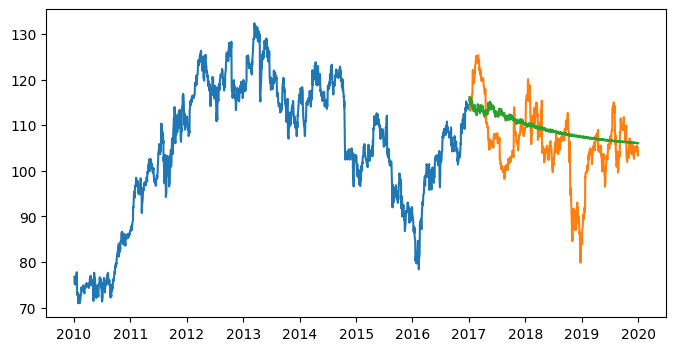

In [29]:
key = '(3, 0, 10, 12)'
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

After adding seasonality the error is slightly bigger but the graph is no longer simply a line.

# 4. Facebook Prophet

In [30]:
df_prophet = data.copy()
df_prophet['Date'] = pd.to_datetime(df_prophet['Date'])
df_prophet = df_prophet[df_prophet['Symbol'] == 'IBM']
new_df = df_prophet[['Date', 'Adj Close']].rename(columns={'Date': 'ds', 'Adj Close': 'y'})
new_df.head()

,ds,y
235658,2010-01-04,76.767426
235659,2010-01-05,75.840080
235660,2010-01-06,75.347420
235661,2010-01-07,75.086586
235662,2010-01-08,75.840080


In [31]:
X_train, X_test = train_test_split(new_df, test_size=0.3, shuffle=False)

12:20:25 - cmdstanpy - INFO - Chain [1] start processing
12:20:25 - cmdstanpy - INFO - Chain [1] done processing


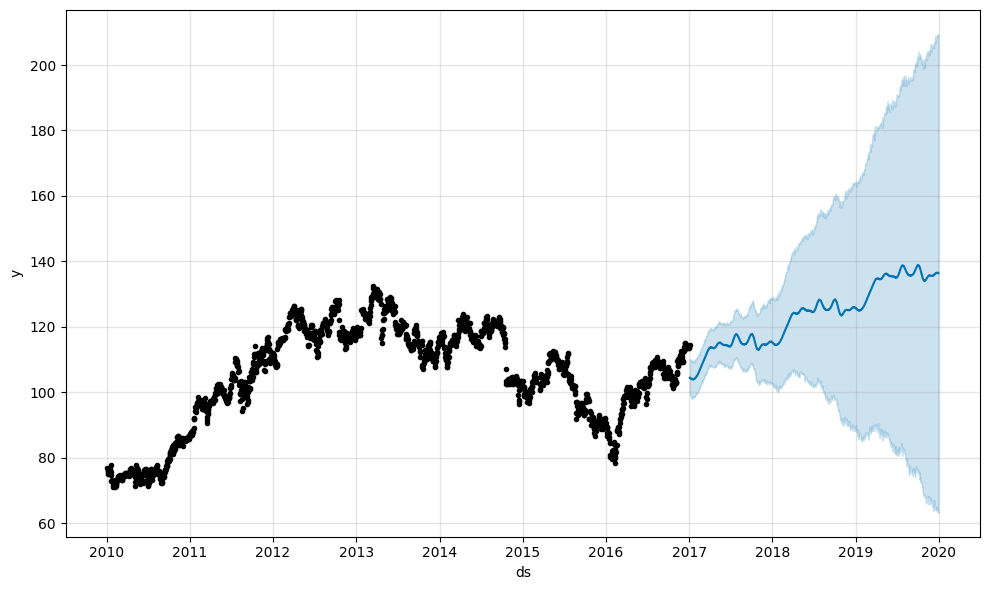

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-04,108.139479,99.118171,110.080615,108.139479,108.139479,-3.690494,-3.690494,-3.690494,-0.212393,-0.212393,-0.212393,-3.478101,-3.478101,-3.478101,0.0,0.0,0.0,104.448985
1,2017-01-05,108.168293,99.388653,110.189046,108.168293,108.168293,-3.661210,-3.661210,-3.661210,-0.086223,-0.086223,-0.086223,-3.574987,-3.574987,-3.574987,0.0,0.0,0.0,104.507083
2,2017-01-06,108.197107,99.002943,110.175987,108.197107,108.197107,-3.834371,-3.834371,-3.834371,-0.163265,-0.163265,-0.163265,-3.671106,-3.671106,-3.671106,0.0,0.0,0.0,104.362735
3,2017-01-09,108.283549,99.102495,109.531152,108.283549,108.283549,-4.107405,-4.107405,-4.107405,-0.163898,-0.163898,-0.163898,-3.943507,-3.943507,-3.943507,0.0,0.0,0.0,104.176144
4,2017-01-10,108.312363,98.297414,109.755489,108.312363,108.312363,-4.197779,-4.197779,-4.197779,-0.172118,-0.172118,-0.172118,-4.025661,-4.025661,-4.025661,0.0,0.0,0.0,104.114584


In [32]:
model = Prophet()
model.fit(X_train)
forecast = model.predict(X_test)
model.plot(forecast)
plt.show()
forecast.head()

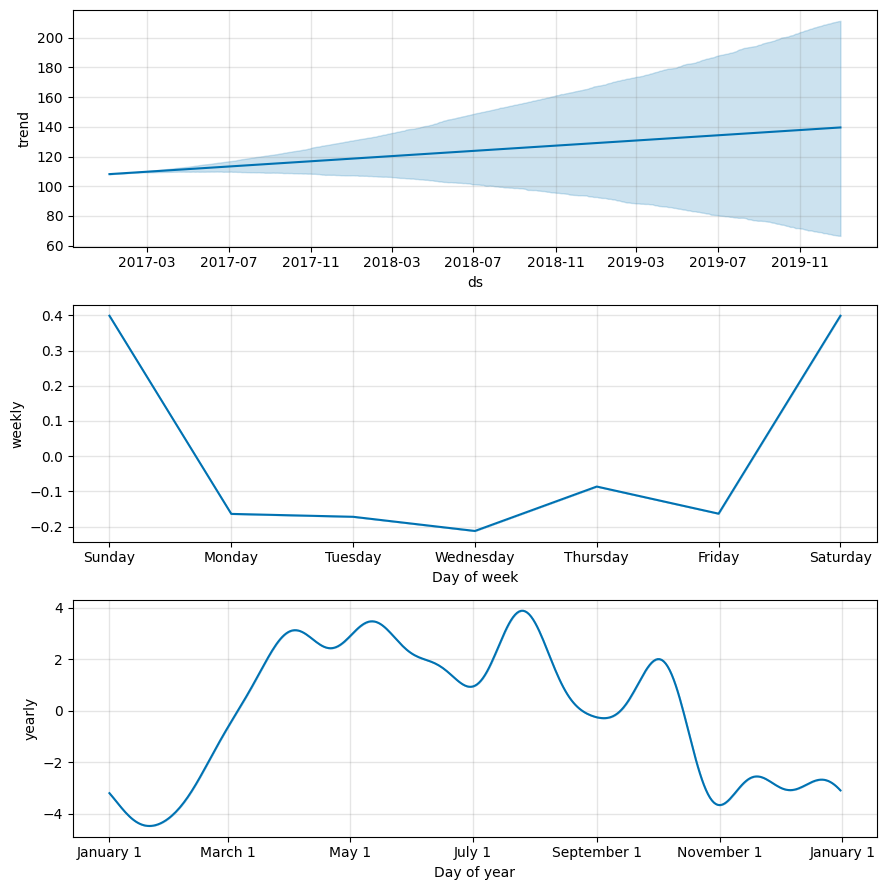

In [33]:
model.plot_components(forecast)
plt.show()

In [34]:
mse = np.sqrt(mean_squared_error(X_test['y'], forecast['yhat']))
mae = mean_absolute_error(X_test['y'], forecast['yhat'])

print(f'Mean Square Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Square Error: 22.616927379715854
Mean Absolute Error: 19.97737043531076


In [35]:
res = {}

def convert_inputs_to_strings(func):
    def wrapper(*args, **kwargs):
        str_kwargs = {key: str(value) for key, value in kwargs.items()}
        inputs_as_string = f"{str_kwargs}"
        result = func(inputs_as_string, *args, **kwargs)
        return result
    return wrapper

@convert_inputs_to_strings
def Proph(inputs_as_string, X_train, X_test, holidays=None, seasonality_name='None', period=0, fourier_order=0):
    model = Prophet(holidays=market_crashes, weekly_seasonality=False, yearly_seasonality=False)
    model.add_seasonality(name=seasonality_name, period=period, fourier_order=fourier_order)
    model.fit(X_train)
    forecast = model.predict(X_test)

    mse = np.sqrt(mean_squared_error(X_test['y'], forecast['yhat']))
    mae = mean_absolute_error(X_test['y'], forecast['yhat'])
    
    res[inputs_as_string] = {
        'mse': mse,
        'mae': mae,
        'predictions': forecast
    }

In [36]:
market_crashes = pd.DataFrame({
  'holiday': 'market crashes',
  'ds': pd.to_datetime(['2010-05-06','2011-08-06', '2015-08-18',
                        '2020-03-09', '2013-01-24'])
})

In [37]:
Proph(X_train, X_test, market_crashes, seasonality_name='yearly', period=365.25, fourier_order=5)
Proph(X_train, X_test, market_crashes, seasonality_name='yearly', period=365.25, fourier_order=6)
Proph(X_train, X_test, market_crashes, seasonality_name='yearly', period=365.25, fourier_order=7)
Proph(X_train, X_test, market_crashes, seasonality_name='yearly', period=365.25, fourier_order=8)
Proph(X_train, X_test, market_crashes, seasonality_name='yearly', period=365.25, fourier_order=9)

Proph(X_train, X_test, market_crashes, seasonality_name='weekly', period=7, fourier_order=5)
Proph(X_train, X_test, market_crashes, seasonality_name='weekly', period=7, fourier_order=8)
Proph(X_train, X_test, market_crashes, seasonality_name='weekly', period=7, fourier_order=9)
Proph(X_train, X_test, market_crashes, seasonality_name='weekly', period=7, fourier_order=10)
Proph(X_train, X_test, market_crashes, seasonality_name='weekly', period=7, fourier_order=11)
Proph(X_train, X_test, market_crashes, seasonality_name='weekly', period=7, fourier_order=12)
Proph(X_train, X_test, market_crashes, seasonality_name='weekly', period=7, fourier_order=20)

df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:29 - cmdstanpy - INFO - Chain [1] done processing
12:20:30 - cmdstanpy - INFO - Chain [1] start processing
12:20:31 - cmdstanpy - INFO - Chain [1] done processing
12:20:31 - cmdstanpy - INFO - Chain [1] start processing
12:20:32 - cmdstanpy - INFO - Chain [1] done processing
12:20:33 - cmdstanpy - INFO - Chain [1] start processing
12:20:34 - cmdstanpy - INFO - Chain [1] done processing
12:20:34 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:36 - cmdstanpy - INFO - Chain [1] start processing
12:20:37 - cmdstanpy - INFO - Chain [1] done processing
12:20:37 - cmdstanpy - INFO - Chain [1] start processing
12:20:38 - cmdstanpy - INFO - Chain [1] done processing
12:20:39 - cmdstanpy - INFO - Chain [1] start processing
12:20:39 - cmdstanpy - INFO - Chain [1] done processing
12:20:40 - cmdstanpy - INFO - Chain [1] start processing
12:20:41 - cmdstanpy - INFO - Chain [1]

,mse,mae
"{'seasonality_name': 'yearly', 'period': '365.25', 'fourier_order': '5'}",22.207550,19.620678
"{'seasonality_name': 'yearly', 'period': '365.25', 'fourier_order': '6'}",22.716125,20.064561
"{'seasonality_name': 'yearly', 'period': '365.25', 'fourier_order': '7'}",22.911102,20.244029
"{'seasonality_name': 'yearly', 'period': '365.25', 'fourier_order': '8'}",22.210648,19.608033
"{'seasonality_name': 'yearly', 'period': '365.25', 'fourier_order': '9'}",22.567159,19.936607
"{'seasonality_name': 'weekly', 'period': '7', 'fourier_order': '5'}",20.206866,17.453189
"{'seasonality_name': 'weekly', 'period': '7', 'fourier_order': '8'}",19.813759,17.088493
"{'seasonality_name': 'weekly', 'period': '7', 'fourier_order': '9'}",19.727467,17.010197
"{'seasonality_name': 'weekly', 'period': '7', 'fourier_order': '10'}",19.057728,16.393536
"{'seasonality_name': 'weekly', 'period': '7', 'fourier_order': '11'}",19.942889,17.208192


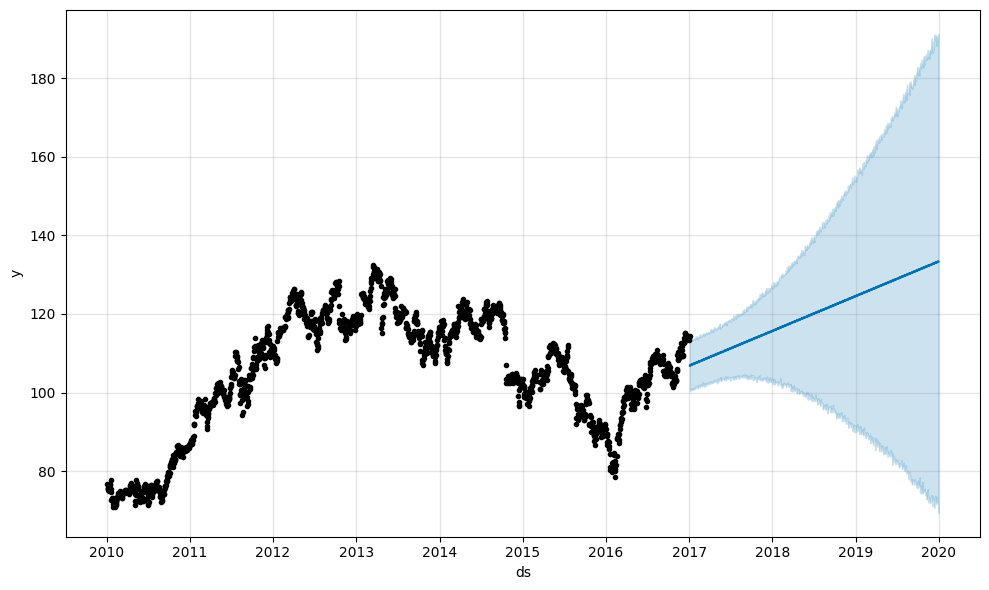

In [38]:
key = "{'seasonality_name': 'weekly', 'period': '7', 'fourier_order': '10'}"
pred = res[key]['predictions']
model.plot(pred)
plt.show()

After playing with hiperparameters the error was slightly reduced but overall Prophet gives the worst prediction of all previous algorithms. 

# 5. RandomForestRegressor 

In [39]:
df_forest = data.copy()
df_forest['Date'] = pd.to_datetime(df_forest['Date'])
df_forest = df_forest.set_index('Date')
df_forest = df_forest[df_forest['Symbol'] == 'IBM']

X = df_forest[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
y = df_forest[['Adj Close']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [40]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Square Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Square Error: 13.154322073122437
Mean Absolute Error: 12.408679752172544


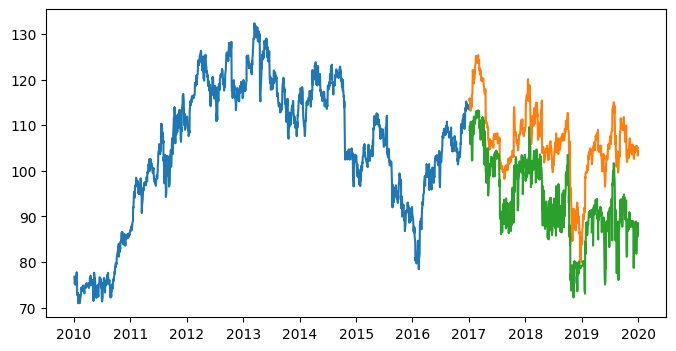

In [41]:
line_graph_pred(y_train, y_test, y_pred)

Even though error is greater than when using ExponentialSmoothing and ARIMA, the prediction grpah looks the best of all previous algorithms.

# 6. Generated signal

In [42]:
from scipy import signal
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

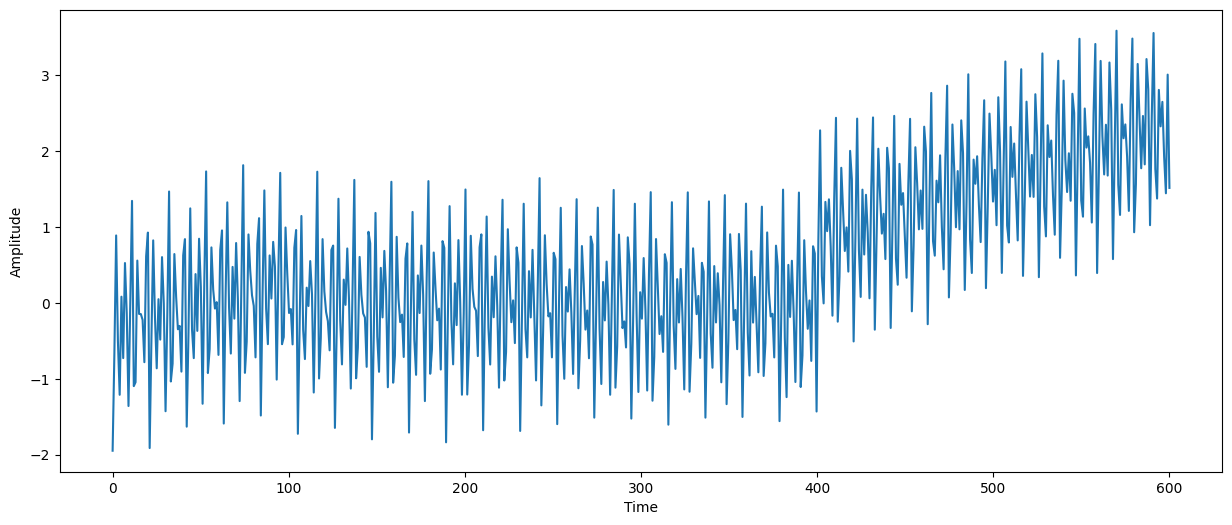

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(t, pts)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

The generated signal consists of:

* high-frequency triangular waveform (triangle1)
* lower frequency, asymmetric triangular waveform (triangle2)
* several linear trends (trend, trend1, trend2, trend3)
* gaussian noise (noise)

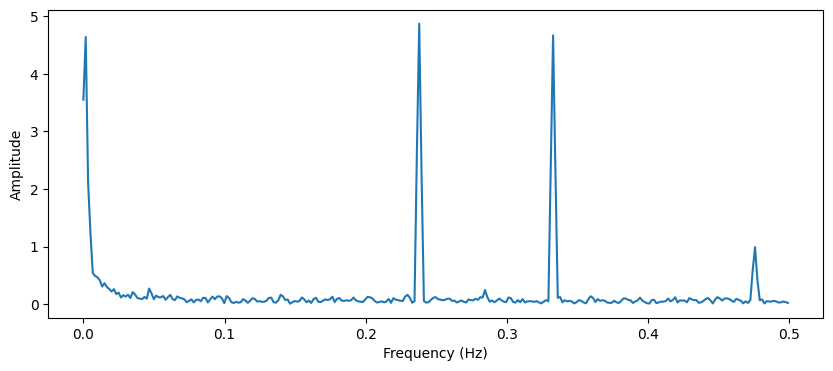

In [44]:
pts2 = pts.copy()
pts2 -= np.mean(pts2)
pts2 *= scipy.signal.windows.hann(len(pts2))

fft = np.fft.rfft(pts2, norm="ortho")
freqs = np.fft.rfftfreq(len(pts2), d=(t[1]-t[0]))

plt.figure(figsize=(10,4))
plt.plot(freqs, abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

By using Fourier transform we can show periodicity in the generated signal.

Value of the trend: 2.6895683972164033


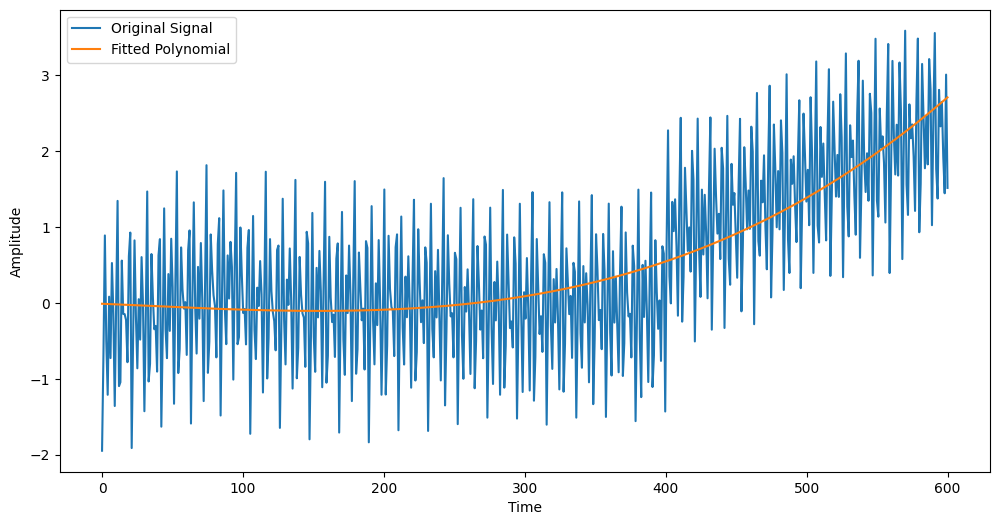

In [45]:
degree = 3
coefficients = np.polyfit(t, pts, degree)
polynomial = np.poly1d(coefficients)

fitted_vals = polynomial(t)
print(f'Value of the trend: {fitted_vals[-2]}')

plt.figure(figsize=(12, 6))
plt.plot(t, pts, label='Original Signal')
plt.plot(t, fitted_vals, label=f'Fitted Polynomial')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

By using np.polyfit we can se that the signal has a slight upwards trend.

## 6.1. Exponential Smoothing

In [46]:
res = {}
ExpSmFun(pts_train, pts_test, seasonal_periods=20, trend='additive', seasonal='additive')
ExpSmFun(pts_train, pts_test, seasonal_periods=24, trend='additive', seasonal='additive')

df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"{'seasonal_periods': '20', 'trend': 'additive', 'seasonal': 'additive'}",0.829864,0.674094
"{'seasonal_periods': '24', 'trend': 'additive', 'seasonal': 'additive'}",0.615802,0.521994


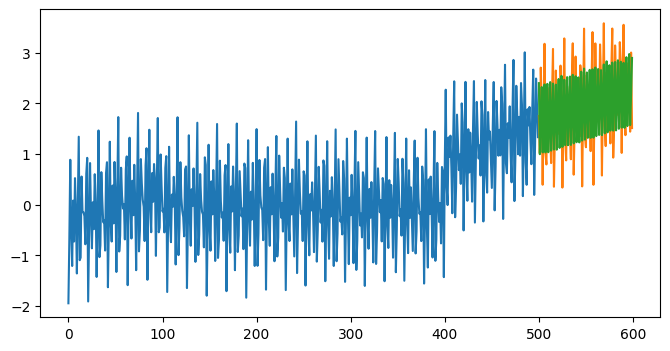

In [47]:
key = "{'seasonal_periods': '24', 'trend': 'additive', 'seasonal': 'additive'}"
pred = res[key]['predictions']
X_train = pd.DataFrame(pts_train, columns=['values'], index=range(0, n_train_rows))
X_test = pd.DataFrame(pts_test, columns=['values'], index = range(n_train_rows, last_n_rows))
line_graph_pred(X_train, X_test, pred)

## 6.2. ARIMA

In [48]:
X_train = pd.DataFrame(pts_train, columns=['values'], index=range(0, n_train_rows))
X_test = pd.DataFrame(pts_test, columns=['values'], index = range(n_train_rows, last_n_rows))

In [49]:
res = {}
for p in range(1, 11):
    mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, p, 0, 0)
    res[str((p, d, q))] = {
        'mse': mse,
        'mae': mae,
        'predictions': pred,
        'interval': conf_int
    }
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(1, 0, 0)",1.938473,1.756725
"(2, 0, 0)",1.942599,1.762989
"(3, 0, 0)",1.891156,1.693871
"(4, 0, 0)",1.836467,1.629612
"(5, 0, 0)",1.156967,0.952564
"(6, 0, 0)",0.781137,0.604873
"(7, 0, 0)",0.686092,0.528937
"(8, 0, 0)",0.659637,0.504623
"(9, 0, 0)",0.471129,0.384303
"(10, 0, 0)",0.555071,0.446694


In [50]:
res = {}
for q in range(9, 15):
    mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 0, 0, q)
    res[str((p, d, q))] = {
        'mse': mse,
        'mae': mae,
        'predictions': pred,
        'interval': conf_int
    }
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(0, 0, 9)",1.893373,1.693476
"(0, 0, 10)",1.899987,1.704110
"(0, 0, 11)",1.898248,1.703767
"(0, 0, 12)",1.866975,1.655042
"(0, 0, 13)",1.866087,1.654401
"(0, 0, 14)",1.866026,1.656828


In [51]:
res = {}
for d in range(0, 5):
    mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 0, d, 0)
    res[str((p, d, q))] = {
        'mse': mse,
        'mae': mae,
        'predictions': pred,
        'interval': conf_int
    }
df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(0, 0, 0)",1.939519,1.758272
"(0, 1, 0)",1.038978,0.848921
"(0, 2, 0)",36.914119,32.116175
"(0, 3, 0)",238.342982,183.748575
"(0, 4, 0)",111812.331296,74479.770794


In [52]:
res = {}
mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 9, 1, 12)
res[str((p, d, q, s))] = {
    'mse': mse,
    'mae': mae,
    'predictions': pred,
    'interval': conf_int
}
mse, mae, (p, d, q), s, pred, conf_int = ARIMA_model(X_train, X_test, 9, 1, 12, 2, season=True)
res[str((p, d, q, s))] = {
    'mse': mse,
    'mae': mae,
    'predictions': pred,
    'interval': conf_int
}

df = pd.DataFrame.from_dict(res, orient='index')[['mse', 'mae']]
df

,mse,mae
"(9, 1, 12, 0)",0.380405,0.298823
"(9, 1, 12, 2)",0.435601,0.357815


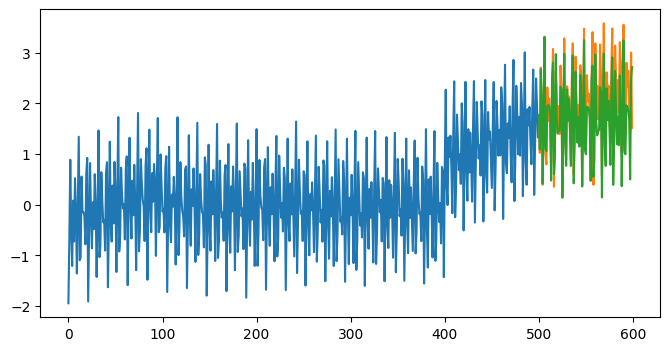

In [53]:
key = "(9, 1, 12, 2)"
pred = res[key]['predictions']
line_graph_pred(X_train, X_test, pred)

## 6.3. Prophet

In [54]:
index_train = pd.date_range(start='2023-01-01', periods=n_train_rows, freq='D')
index_test = pd.date_range(start=index_train[-1] + pd.Timedelta(days=1), periods=len(pts_test), freq='D')

df_train = pd.DataFrame({'ds': index_train, 'y': pts_train})
df_test = pd.DataFrame({'ds': index_test, 'y': pts_test})

In [55]:
model = Prophet()
model.fit(df_train)
forecast = model.predict(df_test)

mse = np.sqrt(mean_squared_error(df_test['y'], forecast['yhat']))
mae = mean_absolute_error(df_test['y'], forecast['yhat'])

print(f'Mean Square Error: {mse}')
print(f'Mean Absolute Error: {mae}')

12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Square Error: 0.8951000162976682
Mean Absolute Error: 0.7274809405548376


In [56]:
model = Prophet(weekly_seasonality=False, yearly_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=12)
model.fit(df_train)
forecast = model.predict(df_test)

mse = np.sqrt(mean_squared_error(df_test['y'], forecast['yhat']))
mae = mean_absolute_error(df_test['y'], forecast['yhat'])

print(f'Mean Square Error: {mse}')
print(f'Mean Absolute Error: {mae}')

12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Square Error: 1.3662096632538339
Mean Absolute Error: 1.1583357441064077


In [57]:
model = Prophet(weekly_seasonality=False, yearly_seasonality=False)
model.add_seasonality(name='weekly', period=7, fourier_order=15)
model.fit(df_train)
forecast = model.predict(df_test)

mse = np.sqrt(mean_squared_error(df_test['y'], forecast['yhat']))
mae = mean_absolute_error(df_test['y'], forecast['yhat'])

print(f'Mean Square Error: {mse}')
print(f'Mean Absolute Error: {mae}')

12:22:46 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Square Error: 0.876927764355473
Mean Absolute Error: 0.7155083164111613


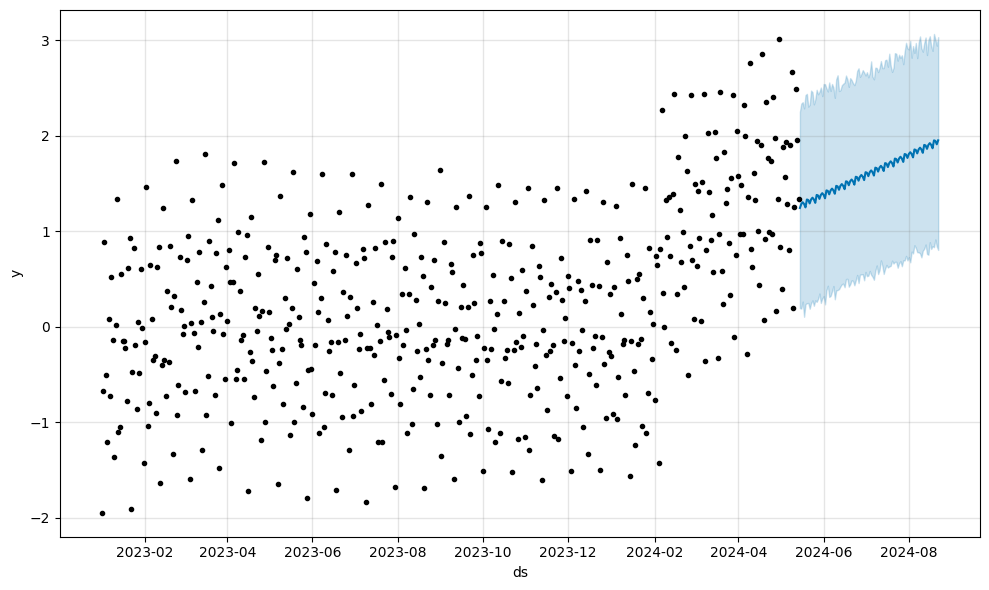

In [58]:
model.plot(forecast)
plt.show()

After applying ExponentialSmoothing, ARIMA and Facebook Prophet on the genereated signal, I was able to obtain the best prediction using ARIMA with extremly low errors.